#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim

In [ ]:
imgs = th.rand(size=(16, 3, 100, 100))
bboxes = th.rand(size=(16, 4))
labels = th.randint(0, 2, size=(16, ))

In [ ]:
class Detector(nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=2),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    n_features = 64 * 49 * 49
    self.classifier = nn.Sequential(
        nn.Linear(n_features, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )

    self.regressor = nn.Sequential(
        nn.Linear(n_features, 64),
        nn.ReLU(),
        nn.Linear(64, 4)
    )

  def forward(self, X):
    features = self.backbone(X).flatten(start_dim=1)
    return self.classifier(features), self.regressor(features)

In [ ]:
model = Detector()
label_pred, bbox_pred = model(imgs)

In [ ]:
import torch.functional as F

In [ ]:
F.cross_entropy(label_pred, labels)
F.mse_loss(bbox_pred, bboxes)

## Задачи для самостоятельного решения

In [1]:
!wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/9Tyq3GGahq5uIA"

200 OK
Length: 25404614 (24M) [application/zip]
Saving to: ‘9Tyq3GGahq5uIA.1’

9Tyq3GGahq5uIA.1    100%[===================>]  24.23M  10.3MB/s    in 2.3s    

2023-12-10 17:31:49 (10.3 MB/s) - ‘9Tyq3GGahq5uIA.1’ saved [25404614/25404614]



In [2]:
from zipfile import ZipFile
with ZipFile('9Tyq3GGahq5uIA') as ZIP:
  ZIP.extractall()

In [3]:
from bs4 import BeautifulSoup
import re
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from PIL import Image
import os
import torchvision.transforms.v2 as T
import torchvision.models as models
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [x] Проверено на семинаре

In [4]:
def parse_xml(xml_file):
  with open(xml_file, 'r') as f:
    soup = BeautifulSoup(f)
    width, height = int(soup.find('width').text), int(soup.find('height').text)
    box = soup.find('bndbox')
    xmin, ymin, xmax, ymax = box.xmin, box.ymin, box.xmax, box.ymax
    dct_raw = {
        'xmin': float(xmin.text),
        'ymin': float(ymin.text),
        'xmax': float(xmax.text),
        'ymax': float(ymax.text)
    }
    dct_scaled = {k: v / width if ('x' in k) else v / height for k, v in dct_raw.items()}
    dct = {
        'obj_name': soup.find('name').text,
        'raw': dct_raw,
        'scaled': dct_scaled
    }
    return dct

In [ ]:
parse_xml('Asirra: cat vs dogs/cat.0.xml')

{'obj_name': 'cat',
 'raw': {'xmin': 126, 'ymin': 83, 'xmax': 354, 'ymax': 243},
 'scaled': {'xmin': 0.252,
  'ymin': 0.22192513368983957,
  'xmax': 0.708,
  'ymax': 0.486}}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [5]:
from torch.utils.data import Dataset

class AnimalDetectionDataset(Dataset):
  def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):
    self.root = root
    files = os.listdir(root)
    files_xml = [file_ for file_ in files if (re.findall(r'(\.xml)', file_) != [])]
    self.files_all = []
    for file_ in files_xml:
      self.files_all.append((file_, file_.replace('xml', 'jpg')))
    self.transforms = transforms
    self.scaled = return_scaled
    self.target_transform = target_transform

  def __getitem__(self, idx):
    file_ = self.files_all[idx]
    img = Image.open(f"{self.root}/{file_[1]}")
    img_t = self.transforms(img)
    data = parse_xml(f'{self.root}/{file_[0]}')
    if self.scaled:
      data.pop('raw')
    else:
      data.pop('scaled')
    return img_t, data

  def __len__(self):
    return len(self.files_all)

In [ ]:
transforms = T.Compose([
    T.ToTensor()
])
dataset = AnimalDetectionDataset('Asirra: cat vs dogs', transforms=transforms, return_scaled=True)

In [11]:
dataset[0]

(tensor([[[0.2510, 0.2549, 0.2588,  ..., 0.1765, 0.1765, 0.1725],
          [0.2549, 0.2549, 0.2588,  ..., 0.1804, 0.1765, 0.1725],
          [0.2549, 0.2588, 0.2627,  ..., 0.1804, 0.1765, 0.1725],
          ...,
          [0.4824, 0.4863, 0.4902,  ..., 0.3373, 0.3373, 0.3373],
          [0.4745, 0.4824, 0.4902,  ..., 0.3412, 0.3373, 0.3333],
          [0.4745, 0.4824, 0.4902,  ..., 0.3412, 0.3373, 0.3333]],
 
         [[0.2275, 0.2314, 0.2353,  ..., 0.1608, 0.1608, 0.1569],
          [0.2314, 0.2314, 0.2353,  ..., 0.1647, 0.1608, 0.1569],
          [0.2314, 0.2353, 0.2392,  ..., 0.1647, 0.1608, 0.1569],
          ...,
          [0.4510, 0.4549, 0.4588,  ..., 0.3137, 0.3137, 0.3137],
          [0.4431, 0.4510, 0.4588,  ..., 0.3176, 0.3137, 0.3098],
          [0.4431, 0.4510, 0.4588,  ..., 0.3176, 0.3137, 0.3098]],
 
         [[0.1647, 0.1686, 0.1725,  ..., 0.1255, 0.1255, 0.1216],
          [0.1686, 0.1686, 0.1725,  ..., 0.1294, 0.1255, 0.1216],
          [0.1686, 0.1725, 0.1765,  ...,

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [6]:
def show_image_with_bounding_box(img_t, bbox):
  name, coord = bbox.values()
  xmin, ymin, xmax, ymax = coord.values()

  plt.imshow(T.ToPILImage()(img_t))
  plt.text(xmin, ymin+5, name, bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 1})
  plt.gca().add_patch(
      Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        edgecolor='red',
        facecolor='none',
        lw=1.5
      )
  )
  plt.axis('off')
  plt.show();

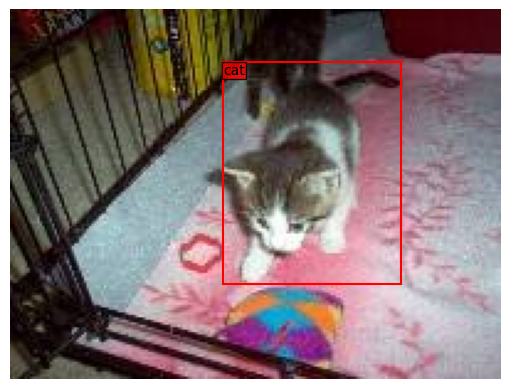

In [20]:
transforms = T.Compose([
    T.ToTensor()
])
dset_raw = AnimalDetectionDataset(
    'Asirra: cat vs dogs',
    transforms=transforms,
    return_scaled=False
)
show_image_with_bounding_box(*dset_raw[0])

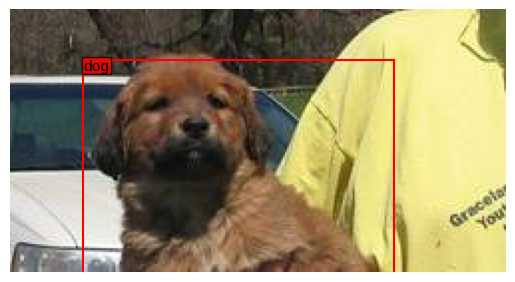

In [21]:
i = 1
while True:
  bbox = dset_raw[i][1]
  if bbox['obj_name'] == 'dog':
    show_image_with_bounding_box(*dset_raw[i])
    break
  i += 1

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [8]:
class Detector(nn.Module):
  def __init__(self, hidden_size, n_classes):
    super().__init__()
    self.backbone = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V1)
    self.backbone.fc = Identity()
    self.backbone.requires_grad_(False)
    n_features = 2048
    self.classifier = nn.Sequential(
        nn.Linear(n_features, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_classes)
    )
    self.regressor = nn.Sequential(
        nn.Linear(n_features, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 4)
    )

  def forward(self, X):
    features = self.backbone(X).flatten(start_dim=1)
    return self.classifier(features), self.regressor(features)

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [9]:
transforms_resnet = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
dset_resnet = AnimalDetectionDataset(
    'Asirra: cat vs dogs',
    transforms=transforms_resnet,
    return_scaled=True
)

gen = th.Generator().manual_seed(42)
train, test = random_split(dset_resnet, [0.8, 0.2], generator=gen)

train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

In [10]:
n_epoch = 10
lr = 0.001
model = Detector(hidden_size=128, n_classes=2)
model.to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr)
labels_enc = {
    'cat': 0,
    'dog': 1
}
CEL = nn.CrossEntropyLoss()
MSE = nn.MSELoss()

for epoch in range(1, n_epoch+1):
  model.train()
  for X_b, y_b in train_loader:
    labels = th.tensor([labels_enc[name] for name in y_b['obj_name']])
    bbox = [t.unsqueeze(1) for t in y_b['scaled'].values()]
    bbox = th.cat(bbox, dim=1).type(th.float32)

    labels_pred, bbox_pred = model(X_b.to(device='cuda'))
    l_loss = CEL(labels_pred, labels.to(device='cuda'))
    bb_loss = MSE(bbox_pred, bbox.to(device='cuda'))
    loss = l_loss + bb_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  model.eval()
  for X_b, y_b in test_loader:
    labels = th.tensor([labels_enc[name] for name in y_b['obj_name']])
    bbox = [t.unsqueeze(1) for t in y_b['scaled'].values()]
    bbox = th.cat(bbox, dim=1).type(th.float32)

    labels_pred, bbox_pred = model(X_b.to(device='cuda'))
    l_loss = CEL(labels_pred, labels.to(device='cuda'))
    bb_loss = MSE(bbox_pred, bbox.to(device='cuda'))
    loss_test = l_loss + bb_loss
  print(f'{epoch=} loss_train={loss.item():.5f} loss_test={loss_test.item():.5f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


epoch=1 loss_train=0.36296 loss_test=0.25701
epoch=2 loss_train=0.20837 loss_test=0.19982
epoch=3 loss_train=0.18775 loss_test=0.18569
epoch=4 loss_train=0.17855 loss_test=0.18085
epoch=5 loss_train=0.16953 loss_test=0.17908
epoch=6 loss_train=0.15923 loss_test=0.18117
epoch=7 loss_train=0.14765 loss_test=0.18439
epoch=8 loss_train=0.13395 loss_test=0.18811
epoch=9 loss_train=0.11928 loss_test=0.19152
epoch=10 loss_train=0.10284 loss_test=0.19385


In [30]:
img, bbox = next(iter(test_loader))
img = img[1].unsqueeze(0)
img.shape

torch.Size([1, 3, 224, 224])

In [31]:
label_pred, bbox_pred = model(img.to(device='cuda'))

In [32]:
label_pred = label_pred.argmax(dim=1).to(device='cpu')
bbox_pred = bbox_pred.abs().squeeze().to(device='cpu')

In [33]:
def inverse_normalize(tensor, mean, std):
  for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m)
  return tensor

img = inverse_normalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

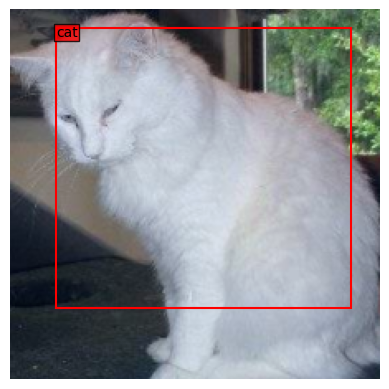

In [37]:
bbox = {
    'name': list(labels_enc.keys())[label_pred.item()],
    'coords': {
        'xmin': bbox_pred[0].detach()*224,
        'ymin': bbox_pred[1].detach()*224,
        'xmax': bbox_pred[2].detach()*224,
        'ymax': bbox_pred[3].detach()*224
    }
}
show_image_with_bounding_box(img.squeeze(), bbox)

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

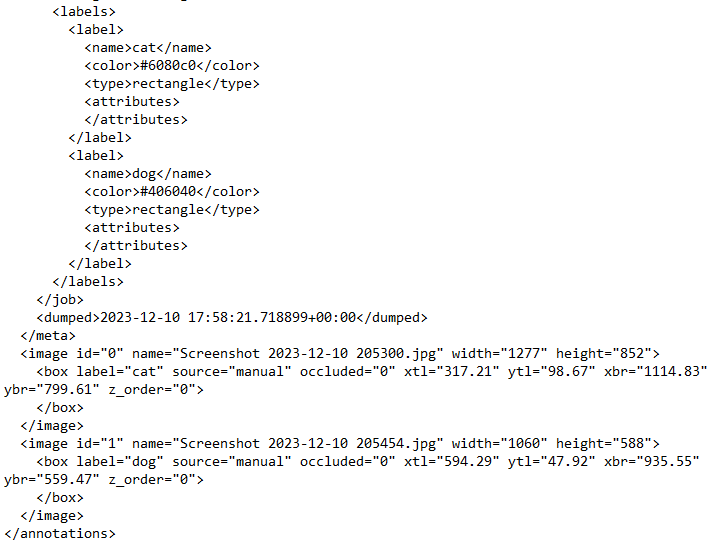

In [76]:
files = [f'pics/{i}.jpg' for i in range(1, 3)]
lst = []
with open('pics/annotations.xml', 'r') as f:
  soup = BeautifulSoup(f)
  imgs = soup.find_all('image')
  dct = {}
  for img in imgs:
    box = img.find('box')
    dct = {
        'name': box['label'],
        'wh': (int(img['height']), int(img['width'])),
        'coords': {
          'xmin': float(box['xtl']),
          'ymin': float(box['ytl']),
          'xmax': float(box['xbr']),
          'ymax': float(box['ybr'])
        }
    }
    lst.append(dct)
lst

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


[{'name': 'cat',
  'wh': (852, 1277),
  'coords': {'xmin': 317.21, 'ymin': 98.67, 'xmax': 1114.83, 'ymax': 799.61}},
 {'name': 'dog',
  'wh': (588, 1060),
  'coords': {'xmin': 594.29, 'ymin': 47.92, 'xmax': 935.55, 'ymax': 559.47}}]

In [77]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
img = Image.open(f"pics/1.jpg")
img_t = transforms(img)
label_pred, bbox_pred = model(img_t.unsqueeze(0).to(device='cuda'))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [78]:
label_pred = label_pred.argmax(dim=1).to(device='cpu')
bbox_pred = bbox_pred.abs().squeeze().to(device='cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


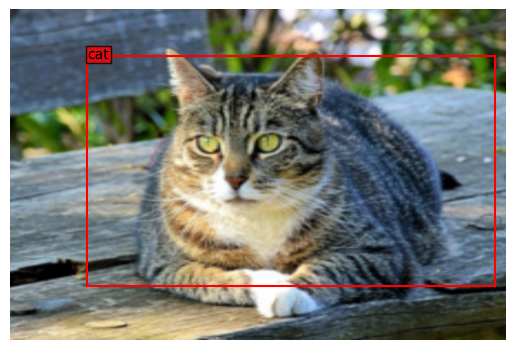

(852, 1277)

In [79]:
# визуализация модели
bbox = {
    'name': list(labels_enc.keys())[label_pred.item()],
    'coords': {
        'xmin': bbox_pred[0].detach()*lst[0]['wh'][1],
        'ymin': bbox_pred[1].detach()*lst[0]['wh'][0],
        'xmax': bbox_pred[2].detach()*lst[0]['wh'][1],
        'ymax': bbox_pred[3].detach()*lst[0]['wh'][0]
    }
}
inv_transform = T.Resize(lst[0]['wh'])
show_image_with_bounding_box(inv_transform(img_t), bbox)
lst[0].pop('wh')

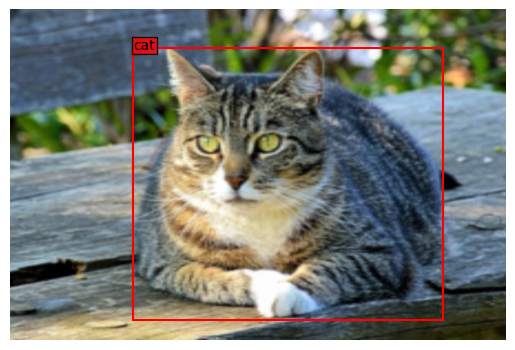

In [80]:
# из CVAT
show_image_with_bounding_box(inv_transform(img_t), lst[0])

In [81]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
img = Image.open(f"pics/2.jpg")
img_t = transforms(img)
label_pred, bbox_pred = model(img_t.unsqueeze(0).to(device='cuda'))

In [82]:
label_pred = label_pred.argmax(dim=1).to(device='cpu')
bbox_pred = bbox_pred.abs().squeeze().to(device='cpu')

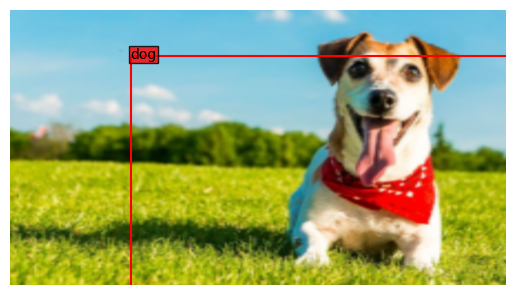

(588, 1060)

In [83]:
# визуализация модели
bbox = {
    'name': list(labels_enc.keys())[label_pred.item()],
    'coords': {
        'xmin': bbox_pred[0].detach()*lst[1]['wh'][1],
        'ymin': bbox_pred[1].detach()*lst[1]['wh'][0],
        'xmax': bbox_pred[2].detach()*lst[1]['wh'][1],
        'ymax': bbox_pred[3].detach()*lst[1]['wh'][0]
    }
}
inv_transform = T.Resize(lst[1]['wh'])
show_image_with_bounding_box(inv_transform(img_t), bbox)
lst[1].pop('wh')

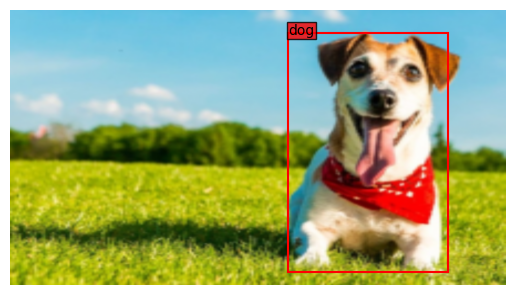

In [84]:
# из CVAT
show_image_with_bounding_box(inv_transform(img_t), lst[1])

<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

## Обратная связь
- [ ] Хочу получить обратную связь по решению